In [1]:
import os
import torch
import timeit
import random
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import soundfile as sf
import matplotlib.pyplot as plt
from sklearn import decomposition
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
w2v_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to(DEVICE)

/afs/inf.ed.ac.uk/user/s20/s2057508/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
path = '/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/Corpora/Berlin/wav'
os.chdir(path)

durs = []
lens = []

for file in os.listdir('.'):
    dur = librosa.get_duration(filename = file)
    audioinput, sr = librosa.load(file)
    durs.append(dur)
    lens.append(len(audioinput))

print(np.mean(np.array(durs)) + np.std(np.array(durs))) # ave duration + std deviation
print(np.mean(np.array(lens)) + np.std(np.array(lens))) # ave duration + std deviation

3.806839123563467
83941.3076730287


In [2]:
path = '/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/Corpora/Berlin/wav'
os.chdir(path)
np.seterr(divide='ignore', invalid='ignore')

spt_A = np.array([])
spt_E = np.array([])
spt_F = np.array([])
spt_L = np.array([])
spt_N = np.array([])
spt_T = np.array([])
spt_W = np.array([])
prd_A = np.array([])
prd_E = np.array([])
prd_F = np.array([])
prd_L = np.array([])
prd_N = np.array([])
prd_T = np.array([])
prd_W = np.array([])

for file in os.listdir('.'):
    print(file)
    spt = np.array([])
    prd = np.array([])
    audioinput, sr = librosa.load(file, sr=16000, duration=3.8)
    audioinput = librosa.util.fix_length(audioinput, size=60800, mode="edge") #pad to same length
    
    #spectral features
    mfcc = librosa.feature.mfcc(y=audioinput, sr=sr, n_mfcc=40)
    mfcc_mean = np.mean(mfcc.T, axis=0)
# #     mels = librosa.feature.melspectrogram(y=audioinput, sr=sr)
# #     mels_del = librosa.feature.delta(mels, order=1)
# #     mels_del2 = librosa.feature.delta(mels, order=2)
    kur_m = kurtosis(mfcc_mean)
    ske_m = skew(mfcc_mean)
    max_m = np.amax(np.array(mfcc_mean), axis=0)
    min_m = np.amin(np.array(mfcc_mean), axis=0)
    ave_m = np.mean(np.array(mfcc_mean), axis=0)
    rag_m = max_m-min_m
    
    for i in (mfcc_mean, kur_m, ske_m, max_m, min_m, ave_m, rag_m):
        spt = np.append(spt, i)
        
    #prosodic features
    eng = librosa.feature.rms(y=audioinput)
    f0, voiced_flag, voiced_probs = librosa.pyin(audioinput,
                                                 fmin=librosa.note_to_hz('C2'),
                                                 fmax=librosa.note_to_hz('C7'))
    kur_e = kurtosis(eng)
    ske_e = skew(eng)
    max_e = np.amax(np.array(eng), axis=0)
    min_e = np.amin(np.array(eng), axis=0)
    ave_e = np.mean(np.array(eng), axis=0)
    rag_e = max_e-min_e
    
    kur_f = kurtosis(f0)
    ske_f = skew(f0)
    max_f = np.amax(np.array(f0), axis=0)
    min_f = np.amin(np.array(f0), axis=0)
    ave_f = np.mean(np.array(f0), axis=0)
    rag_f = max_f-min_f
    
    for i in (eng, f0, kur_e, ske_e, max_e, min_e, ave_e, rag_m, kur_f, ske_f, max_f, min_f, ave_f, rag_f):
        prd = np.append(prd, i)
    
    #w2v features
#     input_values = processor(audioinput, sampling_rate=16000, return_tensors="pt").input_values.to(DEVICE)
#     w2v_feats = w2v_model(input_values, output_hidden_states=True).hidden_states
#     w2v_feats_0 = w2v_feats[0].detach()[0].mean(dim=0)
#     w2v_feats_1 = w2v_feats[1].detach()[0].mean(dim=0)
#     w2v_feats_7 = w2v_feats[7].detach()[0].mean(dim=0)
#     w2v_feats_11 = w2v_feats[11].detach()[0].mean(dim=0)
#     w2v_feats_12 = w2v_feats[12].detach()[0].mean(dim=0)
    
    #separate accroindg to emotions
    if file[5] == 'A':
        spt_A = np.append(spt_A, spt)
        spt_A = np.reshape(spt_A, (-1, spt.size))
        prd_A = np.append(prd_A, prd)
        prd_A = np.reshape(prd_A, (-1, prd.size))
    elif file[5] == 'E':
        spt_E = np.append(spt_E, spt)
        spt_E = np.reshape(spt_E, (-1, spt.size)) 
        prd_E = np.append(prd_E, prd)
        prd_E = np.reshape(prd_E, (-1, prd.size))
    elif file[5] == 'F':
        spt_F = np.append(spt_F, spt)
        spt_F = np.reshape(spt_F, (-1, spt.size))
        prd_F = np.append(prd_F, prd)
        prd_F = np.reshape(prd_F, (-1, prd.size))
    elif file[5] == 'L':
        spt_L = np.append(spt_L, spt)
        spt_L = np.reshape(spt_L, (-1, spt.size))
        prd_L = np.append(prd_L, prd)
        prd_L = np.reshape(prd_L, (-1, prd.size))
    elif file[5] == 'N':
        spt_N = np.append(spt_N, spt)
        spt_N = np.reshape(spt_N, (-1, spt.size))
        prd_N = np.append(prd_N, prd)
        prd_N = np.reshape(prd_N, (-1, prd.size))       
    elif file[5] == 'T':
        spt_T = np.append(spt_T, spt)
        spt_T = np.reshape(spt_T, (-1, spt.size))
        prd_T = np.append(prd_T, prd)
        prd_T = np.reshape(prd_T, (-1, prd.size))
    elif file[5] == 'W':
        spt_W = np.append(spt_W, spt)
        spt_W = np.reshape(spt_W, (-1, spt.size))
        prd_W = np.append(prd_W, prd)
        prd_W = np.reshape(prd_W, (-1, prd.size))

print('finished')

/afs/inf.ed.ac.uk/user/s20/s2057508/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


NoBackendError: 

In [7]:
spt_feats = np.vstack((spt_A, spt_E, spt_F, spt_L, spt_N, spt_T, spt_W))
prd_feats = np.vstack((prd_A, prd_E, prd_F, prd_L, prd_N, prd_T, prd_W))
print(spt_feats.shape, prd_feats.shape)

(535, 46) (535, 840)


In [14]:
labels = [0] * 69 + [1] * 46 + [2] * 71 + [3] * 81 + [4] * 79 + [5] * 62 + [6] * 127
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

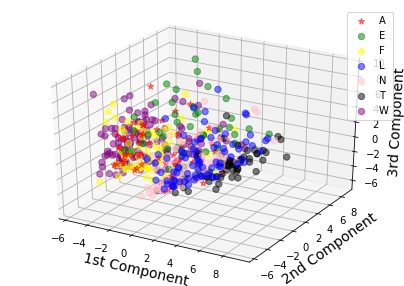

In [17]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

X = spt_feats
Y = labels

scaler = StandardScaler()
scaler.fit(X) 
X_scaled = scaler.transform(X)

pca = PCA(n_components=3)
pca.fit(X_scaled) 
X_pca = pca.transform(X_scaled) 

ex_variance=np.var(X_pca,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
ex_variance_ratio

Xax = X_pca[:,0]
Yax = X_pca[:,1]
Zax = X_pca[:,2]

cdict = {0:'red',1:'green',2:'yellow',3:'blue',4:'pink',5:'black',6:'purple'}
labl = {0:'A',1:'E',2:'F',3:'L',4:'N',5:'T',6:'W'}
marker = {0:'*',1:'o',2:'o',3:'o',4:'o',5:'o',6:'o'}
alpha = {0:.5,1:.5,2:.5,3:.5,4:.5,5:.5,6:.5}

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white')
for l in np.unique(Y):
    ix=np.where(Y==l)
    ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40, label=labl[l], marker=marker[l], alpha=alpha[l])
# for loop ends
ax.set_xlabel("1st Component", fontsize=14)
ax.set_ylabel("2nd Component", fontsize=14)
ax.set_zlabel("3rd Component", fontsize=14)

ax.legend()
plt.show()

In [6]:
import h5py
hf = h5py.File('/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/Corpora/Berlin/hand_feats.h5', 'w')
hf.create_dataset('spt_A', data=spt_A)
hf.close()

In [4]:
hf = h5py.File('/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/Corpora/Berlin/hand_feats.h5', 'r')
f1 = hf.get('spt_A')
f2 = hf.get('spt_E')
f3 = hf.get('spt_F')
f4 = hf.get('spt_L')
f5 = hf.get('spt_T')
f6 = hf.get('spt_W')
print(f1.shape, f2.shape, f3.shape, f4.shape, f5.shape, f6.shape)
hand_feats = f1.append(f2)
hf.close()

NameError: name 'h5py' is not defined

In [19]:
labels = ['0'] * 69 + ['1'] * 46 + ['2'] * 71 + ['3'] * 81 + ['4'] * 62 + ['5'] * 127
print(labels)

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3',

In [1]:
pca = decomposition.PCA(n_components=3)

pca.fit(spt)
spt = pca.transform(spt) 

from sklearn.preprocessing import StandardScaler
spt_A = StandardScaler().fit_transform(spt_A)
pca.fit(spt_A)
spt_A = pca.transform(spt_A) 
print(pca.components_)

NameError: name 'pca' is not defined

In [158]:
from mpl_toolkits.mplot3d import Axes3D

Xax = spt_A[:,0]
Yax = spt_A[:,1]
Zax = spt_A[:,2]

cdict = {0:'red',1:'green',2:'blue'}
labl = {0:'A',1:'B',2:'C'}
marker = {0:'*',1:'o',2:'-'}
alpha = {0:.3, 1:.5, 2:.5}

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white')
for l in np.unique(y):
 ix=np.where(y==l)
 ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40,
           label=labl[l], marker=marker[l], alpha=alpha[l])
# for loop ends
ax.set_xlabel("First Principal Component", fontsize=14)
ax.set_ylabel("Second Principal Component", fontsize=14)
ax.set_zlabel("Third Principal Component", fontsize=14)

ax.legend()
plt.show()

(3, 46291)


In [58]:
import numpy as np
from sklearn.decomposition import PCA

X = np.random.rand(1000, 5, 10)

X_transform = np.zeros((X.shape[0], 5, 5))
for i in range(X.shape[1]):

    pca = PCA(n_components=5)
    f  = pca.fit_transform(X[:, i, :])

    X_transform[:, i, :] = f

print((X_transform.shape))

(1000, 5, 5)


In [25]:
df1 = pd.DataFrame(A)
df2 = pd.DataFrame(B)
# sns.distplot(df)

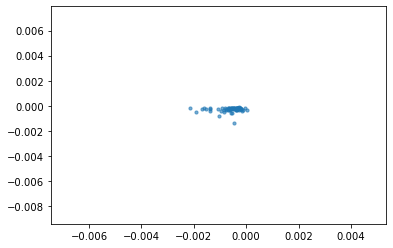

In [28]:
import matplotlib.pyplot as plt
plt.scatter(df1, df2[:69], alpha = 0.6, s=10)

In [27]:
print(len(A),len(B))

69 127
